Importing all required Libraries and packages for the model building and data

In [1]:
!pip install scikit-learn
!pip install 'nltk==3.4.5'

     |████████████████████████████████| 1.5MB 4.9MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449906 sha256=e37bc35c8d5e445081199f29d88bc019a0355356fefaf26fd3d5045f55459c2b
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [0]:
import re
from sklearn.model_selection import train_test_split

In [0]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from tensorflow.keras import layers

Using TensorFlow backend.


Now, we will get our dataset from Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "drive/My Drive/Colab Dataset/IMDB-Dataset.csv"
IMDBFull = pd.read_csv(path)

In [0]:
IMDBFull.shape

(50000, 2)

Clearing the data of unwanted spaces and other symbols

In [0]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [0]:
X = []
sentences = list(IMDBFull['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Defining the sentiments as 1 for Positive and 0 for negative

In [0]:
y = IMDBFull['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

Now, we will split the data. At first the data is split into test and training set (40000:10000), then in second step the training data is again split get the validation data. So that there is ratio of (25000,15000,10000::Train,Validation,Test)

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [0]:
X_train,X_val,y_train,Y_val=train_test_split(X_train,y_train,test_size=0.375)

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val=tokenizer.texts_to_sequences(X_val)

Padding to define a set limit of the input sequences.

In [0]:
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)

We will create a single LSTM-layer model now, with state size=256. We are also adding a dropout layer before the output, and also in the LSTM layer, so that overfitting is avoided. Since this dataset is already built on indexing, so we will be taking top 5000 words.

In [0]:
embedding_vector_len = 32
num_words=5000
model = Sequential()
model.add(Embedding(num_words, embedding_vector_len, input_length=max_words))
model.add(LSTM(256, dropout=0.1))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               295936    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 456,193
Trainable params: 456,193
Non-trainable params: 0
_________________________________________________________________
None


Training the model on training data and validation data.

In [0]:
history = model.fit(X_train, y_train, validation_data=(X_val, Y_val), epochs=3, batch_size=512)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 15000 samples
Epoch 1/3
25000/25000 [==============================] - 651s 26ms/step - loss: 0.6994 - accuracy: 0.6102 - val_loss: 0.6756 - val_accuracy: 0.6788
Epoch 2/3
25000/25000 [==============================] - 692s 28ms/step - loss: 0.5230 - accuracy: 0.7676 - val_loss: 0.4042 - val_accuracy: 0.8161
Epoch 3/3
25000/25000 [==============================] - 692s 28ms/step - loss: 0.3179 - accuracy: 0.8689 - val_loss: 0.3062 - val_accuracy: 0.8724


In [0]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

10000/10000 [==============================] - 116s 12ms/step
Test Loss: 0.3052330704689026
Test Accuracy: 0.8736000061035156


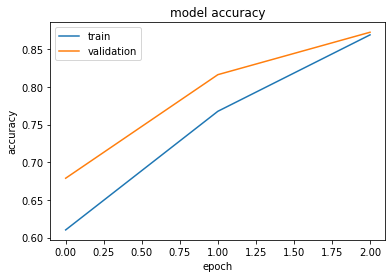

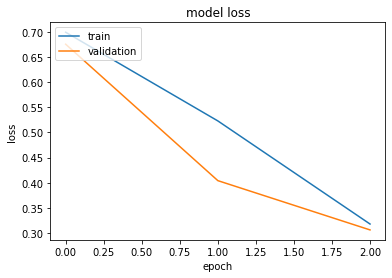

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()